<a href="https://colab.research.google.com/github/ykato27/Auto-Encorder/blob/main/VAE_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VAE-Pytorch

In [1]:
# ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
from torch import optim
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### データローダーの準備

In [3]:
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = "../data"
    download = True
    # 画像にどのような前処理を施すか設定します。
    # ToTensor()の他にもサイズを変更するResize()や標準化を行うnormalize()などを指定できます。
    trans = transforms.ToTensor()
    # まず、torchvision.datasetsからMNISTという手書き数字のデータセットを読み込みます。
    train_set = datasets.MNIST(
        root=root, train=True, transform=trans, download=download
    )
    valid_set = datasets.MNIST(root=root, train=False, transform=trans)
    # データセットをbatch_size個のデータごとに小分けにしたものにして、ミニバッチ学習が可能なようにします。
    # shuffle=True　にすると画像の順序がランダムになったりしますが、ここらへんはどっちでもいいと思います。
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_set, batch_size=batch_size, shuffle=False
    )
    return train_loader, valid_loader

### モデルの設計

In [4]:
class VAE(nn.Module):  # nn.Moduleクラスを引き継ぎ
    def __init__(self, z_dim, x_dim=28 * 28):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        # エンコーダー用の関数
        self.fc1 = nn.Linear(x_dim, 20)
        self.fc2_mean = nn.Linear(20, z_dim)
        self.fc2_var = nn.Linear(20, z_dim)
        # デコーダー用の関数
        self.fc3 = nn.Linear(z_dim, 20)
        self.fc4 = nn.Linear(20, x_dim)

    # エンコーダー
    def encoder(self, x):
        x = x.view(-1, self.x_dim)
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)  # 平均
        log_var = self.fc2_var(x)  # 分散の対数
        return mean, log_var

    # 潜在ベクトルのサンプリング(再パラメータ化)
    def reparametrizaion(self, mean, log_var, device):
        epsilon = torch.randn(mean.shape, device=device)
        return mean + epsilon * torch.exp(0.5 * log_var)

    # デコーダー
    def decoder(self, z):
        y = F.relu(self.fc3(z))
        y = torch.sigmoid(self.fc4(y))  # 各要素にシグモイド関数を適用し、値を(0,1)の範囲に
        return y

    def forward(self, x, device):
        x = x.view(-1, self.x_dim)
        mean, log_var = self.encoder(x)  # 画像xを入力して、平均・分散を出力
        KL = 0.5 * torch.sum(
            1 + log_var - mean ** 2 - torch.exp(log_var)
        )  # KL[q(z|x)||p(z)]を計算
        z = self.reparametrizaion(mean, log_var, device)  # 潜在ベクトルをサンプリング(再パラメータ化)
        x_hat = self.decoder(z)  # 潜在ベクトルを入力して、再構築画像 y を出力
        reconstruction = torch.sum(
            x * torch.log(x_hat + 1e-8) + (1 - x) * torch.log(1 - x_hat + 1e-8)
        )  # E[log p(x|z)]
        lower_bound = -(
            KL + reconstruction
        )  # 変分下界(ELBO)=E[log p(x|z)] - KL[q(z|x)||p(z)]
        return lower_bound, z, x_hat

### 学習

In [5]:
dataloader_train, dataloader_valid = setup_data_loaders(batch_size=1000)  # データローダーを作成
model = VAE(z_dim=10).to(device)  # モデルをインスタンス化し、GPUにのせる
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # オプティマイザーの設定
model.train()  # モデルを訓練モードに
num_epochs = 100
loss_list = []
for i in range(num_epochs):
    losses = []
    for x, t in dataloader_train:  # データローダーからデータを取り出す。
        x = x.to(device)  # データをGPUにのせる
        loss, z, y = model(x, device)  # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad()  # モデルの勾配を初期化
        loss.backward()  # モデル内のパラメータの勾配を計算
        optimizer.step()  # 最適化を実行
        losses.append(loss.cpu().detach().numpy())  # ミニバッチの損失を記録
    loss_list.append(np.average(losses))  # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(i, np.average(losses)))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


EPOCH: 0 loss: 461300.3125
EPOCH: 1 loss: 256464.3125
EPOCH: 2 loss: 228914.65625
EPOCH: 3 loss: 219888.859375
EPOCH: 4 loss: 211361.859375
EPOCH: 5 loss: 203102.828125
EPOCH: 6 loss: 194092.5
EPOCH: 7 loss: 186607.296875
EPOCH: 8 loss: 181463.0
EPOCH: 9 loss: 177231.59375
EPOCH: 10 loss: 173930.40625
EPOCH: 11 loss: 171353.609375
EPOCH: 12 loss: 169322.4375
EPOCH: 13 loss: 167772.5
EPOCH: 14 loss: 166462.609375
EPOCH: 15 loss: 165374.453125
EPOCH: 16 loss: 164317.28125
EPOCH: 17 loss: 163306.546875
EPOCH: 18 loss: 162391.359375
EPOCH: 19 loss: 161442.09375
EPOCH: 20 loss: 160451.734375
EPOCH: 21 loss: 159505.0625
EPOCH: 22 loss: 158658.640625
EPOCH: 23 loss: 157797.015625
EPOCH: 24 loss: 157016.953125
EPOCH: 25 loss: 156230.796875
EPOCH: 26 loss: 155511.953125
EPOCH: 27 loss: 154769.453125
EPOCH: 28 loss: 154017.5
EPOCH: 29 loss: 153334.203125
EPOCH: 30 loss: 152670.953125
EPOCH: 31 loss: 152031.296875
EPOCH: 32 loss: 151411.765625
EPOCH: 33 loss: 150774.1875
EPOCH: 34 loss: 150163.57

### 可視化

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


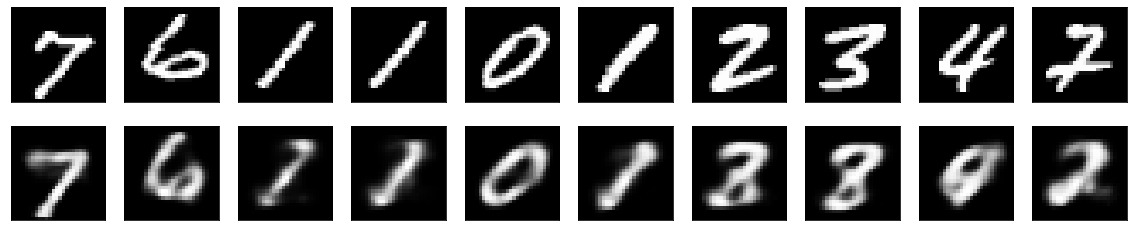

In [6]:
fig = plt.figure(figsize=(20, 4))
model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
        # 元画像を可視化
        ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(im, "gray")
    x = x.to(device)
    _, _, y = model(x, device)  # 再構築画像 y を出力
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
        # 再構築画像を可視化
        ax = fig.add_subplot(2, 10, 11 + i, xticks=[], yticks=[])
        ax.imshow(im, "gray")

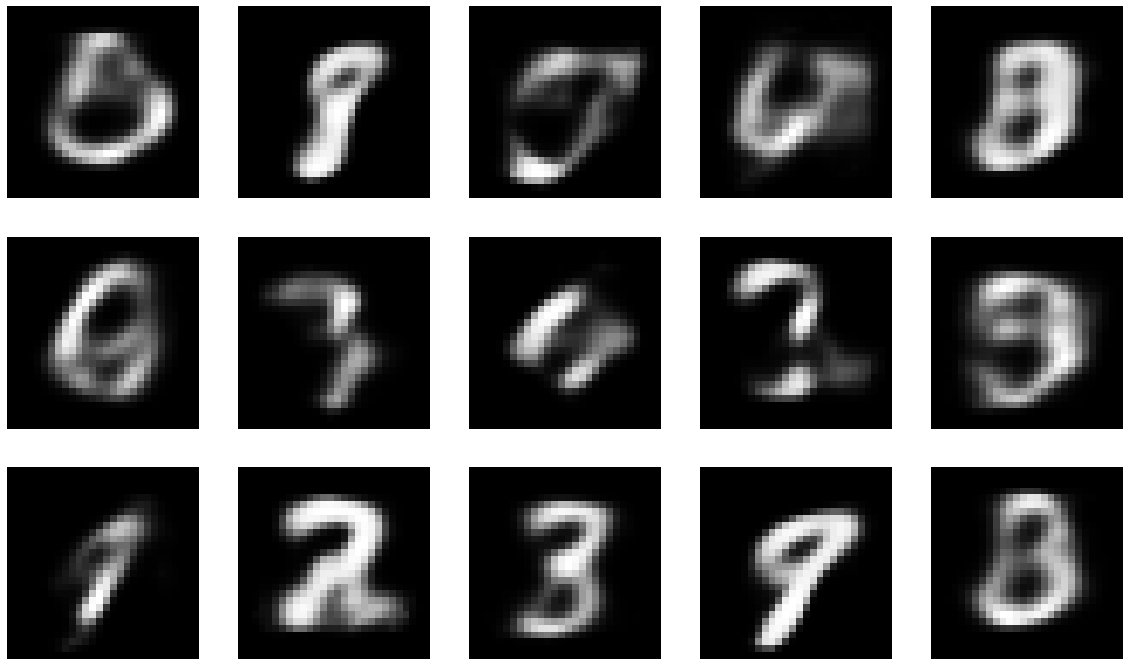

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r, c].imshow(
            model.decoder(torch.randn(10).cuda())
            .detach()
            .cpu()
            .numpy()
            .reshape(28, 28),
            cmap="gray",
        )
        ax[r, c].axis("off")